# ITS_LIVE case study

An example of using **rustac** with [ITS_LIVE](https://its-live.jpl.nasa.gov/) STAC data.
We'll start just by looking at the Landsat ndjson.

<div class="admonition note">
    <p class="admonition-title">AWS credentials</p>
    <p>
        You'll want to make sure you're running this notebook with your AWS credentials configured in your environment, and set your default region to us-west-2.
    </p>
</div>

In [2]:
from pathlib import Path
from obstore.store import S3Store

destination = Path("../../data/its-live")
source_store = S3Store(
    bucket="its-live-data", prefix="test-space/stac_catalogs/landsatOLI/v02"
)

Let's list all of the ndjson files.

In [3]:
import humanize

paths = []
sizes = []
for list_stream in source_store.list():
    for object_meta in list_stream:
        paths.append(object_meta["path"])
        sizes.append(object_meta["size"])

print(
    f"Found {len(paths)} paths with sizes ranging from {humanize.naturalsize(min(sizes))} to {humanize.naturalsize(max(sizes))}"
)
print(f"Total size of the files is {humanize.naturalsize(sum(sizes))}")

Found 5134 paths with sizes ranging from 2.9 kB to 233.0 MB
Total size of the files is 28.7 GB


That's a lot of data!
We'd like to make one or more STAC Collections from it, but we don't really want to store that much ndjson locally.
**stac-geoparquet** is much more compact (especially when compressed) so let's copy-and-convert.

This will take a while, on the order of an hour or two.
An implementation using in-region resources would be faster.

<div class="admonition note">
    <p class="admonition-title">Backfilling errors</p>
    <p>
        The block includes a check for already-existing files, so you can run it multiple times to pick up any files that errored.
    </p>
</div>

In [ ]:
from asyncio import TaskGroup, Semaphore
import tqdm
import rustac

# Limit the number of files we hold in memory at a time
semaphore = Semaphore(10)
# Store the ones that error, it's the internet after all, things will error
missed_paths = []


async def copy_and_convert(
    source_path: str, source_store, destination_path: Path, progress_bar: tqdm.tqdm
) -> None:
    async with semaphore:
        try:
            value = await rustac.read(source_path, store=source_store)
        except Exception:
            missed_paths.append(path)
            progress_bar.update()
            return

        await rustac.write(str(destination_path), value)

        progress_bar.update()


progress_bar = tqdm.tqdm(total=len(paths), miniters=1)
async with TaskGroup() as task_group:
    for path in paths:
        destination_path = Path(destination / path).with_suffix(".parquet")
        if destination_path.exists():
            progress_bar.update()
        else:
            task_group.create_task(
                copy_and_convert(path, source_store, destination_path, progress_bar)
            )

Alright!
Let's see what we got.

In [6]:
import os.path

print(f"{len(missed_paths)} files errored")

count = 0
size = 0
for path in destination.glob("**/*.parquet"):
    count += 1
    size += os.path.getsize(path)

print(f"The {count} stac-geoparquet files are {humanize.naturalsize(size)}")
print(f"That's {100 * size / sum(sizes):.2f}% of the original size")

0 files errored
The 5134 stac-geoparquet files are 3.6 GB
That's 12.53% of the original size


Very cool.
We can use [DuckDB](https://duckdb.org/) to search into the files.

In [7]:
import duckdb

duckdb.sql(f"select count(*) from read_parquet('{destination}/**/*.parquet')")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      9907260 │
└──────────────┘

DuckDB recommends that each partition contains [100 MB](https://duckdb.org/docs/stable/data/partitioning/partitioned_writes.html#partitioned-writes) of data, but some of our files are much smaller.
Let's re-partition our data by year to get larger partitions.

In [22]:
partitioned_destination = "../../data/its-live-partitioned"
# We limit the number of open files to not hose our processor, it defaults to 100
duckdb.sql("set partitioned_write_max_open_files = 4;")
duckdb.sql(
    f"copy (select *, year(datetime) as year from read_parquet('{destination}/**/*.parquet', union_by_name=true)) to '{partitioned_destination}' (format parquet, partition_by (year), overwrite_or_ignore)"
)

We can now query by year effectively.

In [24]:
duckdb.sql(
    f"select count(*) from read_parquet('{partitioned_destination}/**/*.parquet') where year = 2024"
)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1278258 │
└──────────────┘

In [19]:
duckdb.sql(
    f"select column_name from (describe select * from read_parquet('{partitioned_destination}/**/*.parquet'))"
)

┌──────────────────────┐
│     column_name      │
│       varchar        │
├──────────────────────┤
│ type                 │
│ stac_version         │
│ stac_extensions      │
│ id                   │
│ version              │
│ proj:code            │
│ links                │
│ assets               │
│ collection           │
│ datetime             │
│    ·                 │
│    ·                 │
│    ·                 │
│ platform             │
│ scene_1_id           │
│ scene_2_id           │
│ scene_1_path_row     │
│ scene_2_path_row     │
│ sat:orbit_state      │
│ percent_valid_pixels │
│ bbox                 │
│ geometry             │
│ year                 │
├──────────────────────┤
│  27 rows (20 shown)  │
└──────────────────────┘

Each partition's files is still **stac-geoparquet**, so we can read them back in if we want.
Most of them are pretty big, so we intentionally pick a smaller one for this example.

In [10]:
item_collection = await rustac.read(
    str(Path(partitioned_destination) / "year=1982" / "data_0.parquet")
)
print(len(item_collection["features"]))

23


## Searching

One of **rustac**'s features is the ability to use [STAC API search](https://api.stacspec.org/v1.0.0/item-search/) against **stac-geoparquet** files, no server required.
We can use a [cql2](https://github.com/developmentseed/cql2-rs/) filter to query by attributes.

In [15]:
import cql2

href = str(Path(partitioned_destination) / "**" / "*.parquet")
cql2_json = cql2.parse_text("percent_valid_pixels=100").to_json()
items = await rustac.search(href, filter=cql2_json)
print(len(items))

39696


If we know we're going to go to a **geopandas** `GeoDataFrame`, we can search directly to an **arrow** table to make things a bit more efficient.
To do so, we'll need to use **rustac**'s `DuckdbClient`.

<Axes: >

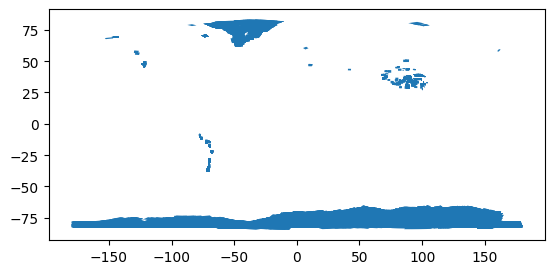

In [18]:
from rustac import DuckdbClient
from geopandas import GeoDataFrame

client = DuckdbClient()
table = client.search_to_arrow(href, filter=cql2_json)
data_frame = GeoDataFrame.from_arrow(table)
data_frame.plot()

## Performance

Let's do a small investigation into the performance characteristics of the two (partitioned, non-partitioned) datasets.
We've uploaded them to the bucket `stac-fastapi-geoparquet-labs-375`, which is public via [requester pays](https://docs.aws.amazon.com/AmazonS3/latest/userguide/RequesterPaysBuckets.html).
In all these examples, we've limited the returned item count to `10`.

In [1]:
import time
from rustac import DuckdbClient

client = DuckdbClient()

href = "s3://stac-fastapi-geoparquet-labs-375/its-live/**/*.parquet"
href_partitioned = (
    "s3://stac-fastapi-geoparquet-labs-375/its-live-partitioned/**/*.parquet"
)

print("Getting the first ten items")
start = time.time()
items = client.search(href, limit=10)
print(
    f"Got {len(items)} items from the non-partitioned dataset in {time.time() - start:.2f} seconds"
)

start = time.time()
items = client.search(href_partitioned, limit=10)
print(
    f"Got {len(items)} items from the partitioned dataset in {time.time() - start:.2f} seconds"
)

building "rustac"
rebuilt and loaded package "rustac" in 8.977s


Getting the first ten items
Got 10 items from the non-partitioned dataset in 7.33 seconds
Got 10 items from the partitioned dataset in 1.34 seconds


In [2]:
print("Searching by year")
start = time.time()
items = client.search(
    href, limit=10, datetime="2024-01-01T00:00:00Z/2024-12-31T23:59:59Z"
)
print(
    f"Got {len(items)} items from 2024 from the non-partitioned dataset in {time.time() - start:.2f} seconds"
)

start = time.time()
items = client.search(
    href_partitioned, limit=10, datetime="2024-01-01T00:00:00Z/2024-12-31T23:59:59Z"
)
print(
    f"Got {len(items)} items from 2024 the partitioned dataset in {time.time() - start:.2f} seconds"
)

Searching by year
Got 10 items from 2024 from the non-partitioned dataset in 19.33 seconds
Got 10 items from 2024 the partitioned dataset in 62.54 seconds


The non-partitioned dataset has much smaller files, so the search for the first ten items in 2024 didn't take as long because it didn't have to read in large datasets across the network.
Let's use the `year` partitioning filter to speed things up.

In [3]:
start = time.time()
items = client.search(
    href_partitioned,
    limit=10,
    datetime="2024-01-01T00:00:00Z/2024-12-31T23:59:59Z",
    filter="year=2024",
)
print(
    f"Got {len(items)} items from 2024 the partitioned dataset, using `year`, in {time.time() - start:.2f} seconds"
)

Got 10 items from 2024 the partitioned dataset, using `year`, in 1.09 seconds


Much better.
Now let's try a spatial search.
During local testing, we determined that it wasn't even worth it to try against the non-partitioned dataset, as it takes too long.

In [5]:
helheim = {"type": "Point", "coordinates": [-38.2, 66.65]}

start = time.time()
items = client.search(href_partitioned, limit=10, intersects=helheim)
print(
    f"Got {len(items)} items over Helheim Glacier from the partitioned dataset in {time.time() - start:.2f} seconds"
)

Got 10 items over Helheim Glacier from the partitioned dataset in 9.33 seconds


For experimentation, we've also got a [stac-fastapi-geoparquet](https://github.com/stac-utils/stac-fastapi-geoparquet/) server pointing to the same partitioned dataset.
Since spatial queries take a lot of data transfer from the DuckDB client to blob storage, is it any faster to query using the **stac-fastapi-geoparquet** lambda?

In [7]:
import rustac
import requests

# Make sure the lambda is started
response = requests.get("https://stac-geoparquet.labs.eoapi.dev")
response.raise_for_status()

start = time.time()
items = await rustac.search(
    "https://stac-geoparquet.labs.eoapi.dev",
    collections=["its-live-partitioned"],
    intersects=helheim,
    max_items=10,
)
print(
    f"Got {len(items)} items over Helheim Glacier from the stac-fastapi-geoparquet server in {time.time() - start:.2f} seconds"
)

Got 10 items over Helheim Glacier from the stac-fastapi-geoparquet server in 2.25 seconds
